Insurance-Cross sell
Objective: To find out which existing customers of health insurance would also be interested in purchasing vehicle insurance
Response variable: 1 indicates buys, 0 indicates not buys
Evaluation metric: ROC-AUC score

**Hypothesis Generation**

1) Are younger people more like to buy insurnace? Since recently it is made compulsory?
2) Are people with DL more likely to buy vehicle insurance?
3) Does region have an effect on purchase decision? 
4) Previously insured people more likely to buy again?
5) New vehicles more likely to buy insurance compared to old vehicles?
6) If customer has had damage in the past, he is more likely to buy vehicle insurance?
7) Higher premium low chances of buying?
8) Effect of channel on sales

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-whitegrid')

import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import KBinsDiscretizer


from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

pd.set_option('display.max_colwidth', -1)

import warnings
warnings.simplefilter('ignore')

<ipython-input-1-0e2bb0513395>:19: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


**Exploratory data analysis**

In [2]:
# Importing the data
train = pd.read_csv(r"C:\Users\rishi\Desktop\GIM\Hackathons\Kaggle-cross sell\train.csv")
test = pd.read_csv(r"C:\Users\rishi\Desktop\GIM\Hackathons\Kaggle-cross sell\test.csv")

In [3]:
# Looking at the data
train.head()
test.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage
0,381110,Male,25,1,11.0,1,< 1 Year,No,35786.0,152.0,53
1,381111,Male,40,1,28.0,0,1-2 Year,Yes,33762.0,7.0,111
2,381112,Male,47,1,28.0,0,1-2 Year,Yes,40050.0,124.0,199
3,381113,Male,24,1,27.0,1,< 1 Year,Yes,37356.0,152.0,187
4,381114,Male,27,1,28.0,1,< 1 Year,No,59097.0,152.0,297


In [4]:
train.shape
test.shape

(381109, 12)

(127037, 11)

Checking data balance

In [5]:
train['Response'].value_counts(normalize=True)

0    0.877437
1    0.122563
Name: Response, dtype: float64

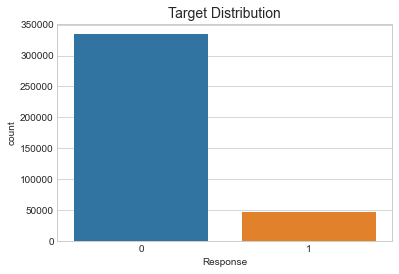

In [6]:
_ = sns.countplot(train['Response'])
_ = plt.title("Target Distribution", fontsize=14)

Number of people not buying is higher in our dataset, will deal with this later

Varibale datatype

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381109 entries, 0 to 381108
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    381109 non-null  int64  
 1   Gender                381109 non-null  object 
 2   Age                   381109 non-null  int64  
 3   Driving_License       381109 non-null  int64  
 4   Region_Code           381109 non-null  float64
 5   Previously_Insured    381109 non-null  int64  
 6   Vehicle_Age           381109 non-null  object 
 7   Vehicle_Damage        381109 non-null  object 
 8   Annual_Premium        381109 non-null  float64
 9   Policy_Sales_Channel  381109 non-null  float64
 10  Vintage               381109 non-null  int64  
 11  Response              381109 non-null  int64  
dtypes: float64(3), int64(6), object(3)
memory usage: 34.9+ MB


Looks like we have only few categorical columns! :D

**Checking data for null values**

In [8]:
null_values_per_variable = 100 * (train.isnull().sum()/train.shape[0]).round(3)#.reset_index()
null_values_per_variable.sort_values(ascending=False)

Response                0.0
Vintage                 0.0
Policy_Sales_Channel    0.0
Annual_Premium          0.0
Vehicle_Damage          0.0
Vehicle_Age             0.0
Previously_Insured      0.0
Region_Code             0.0
Driving_License         0.0
Age                     0.0
Gender                  0.0
id                      0.0
dtype: float64

No null values!

Unique values in each variable

In [9]:
train.nunique()

id                      381109
Gender                  2     
Age                     66    
Driving_License         2     
Region_Code             53    
Previously_Insured      2     
Vehicle_Age             3     
Vehicle_Damage          2     
Annual_Premium          48838 
Policy_Sales_Channel    155   
Vintage                 290   
Response                2     
dtype: int64

Combining train and test to pre-process

In [10]:
combined=pd.concat([train,test],axis=0)

In [11]:
# One hot encoding for gender
combined = pd.get_dummies(combined,columns=['Gender'])
combined = combined.drop(['Gender_Female'], axis = 1)

In [12]:
vehicle_age = {"< 1 Year": 1,
               "1-2 Year": 2,
               "> 2 Years":3}
vehicle_damage = {"Yes":1,"No":0}

combined['Vehicle_Age'] = combined['Vehicle_Age'].map(vehicle_age)
combined['Vehicle_Damage'] = combined['Vehicle_Damage'].map(vehicle_damage)

# binning
premium_discretizer = KBinsDiscretizer(n_bins=8, encode='ordinal', strategy='quantile')
combined['Premium_Bins'] =premium_discretizer.fit_transform(combined['Annual_Premium'].values.reshape(-1,1)).astype(int)

age_discretizer = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='quantile')
combined['Age_Bins'] =age_discretizer.fit_transform(combined['Age'].values.reshape(-1,1)).astype(int)

In [13]:
# splitting back into train and test
train_proc, test_proc = combined[:train.shape[0]], combined[train.shape[0]:].reset_index(drop = True)

# EDA - Univariate analysis

In [14]:
col_names = train_proc.columns

In [15]:
col_names = col_names.drop(['id','Response'])

In [16]:
train_proc

,id,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response,Gender_Male,Premium_Bins,Age_Bins
0,1,44,1,28.0,0,3,1,40454.0,26.0,217,1.0,1,5,6
1,2,76,1,3.0,0,2,0,33536.0,26.0,183,0.0,1,3,9
2,3,47,1,28.0,0,3,1,38294.0,26.0,27,1.0,1,4,7
3,4,21,1,11.0,1,1,0,28619.0,152.0,203,0.0,1,2,0
4,5,29,1,41.0,1,1,0,27496.0,152.0,39,0.0,0,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
381104,381105,74,1,26.0,1,2,0,30170.0,26.0,88,0.0,1,2,9
381105,381106,30,1,37.0,1,1,0,40016.0,152.0,131,0.0,1,5,4
381106,381107,21,1,30.0,1,1,0,35118.0,160.0,161,0.0,1,3,0
381107,381108,68,1,14.0,0,3,1,44617.0,124.0,74,0.0,0,5,9


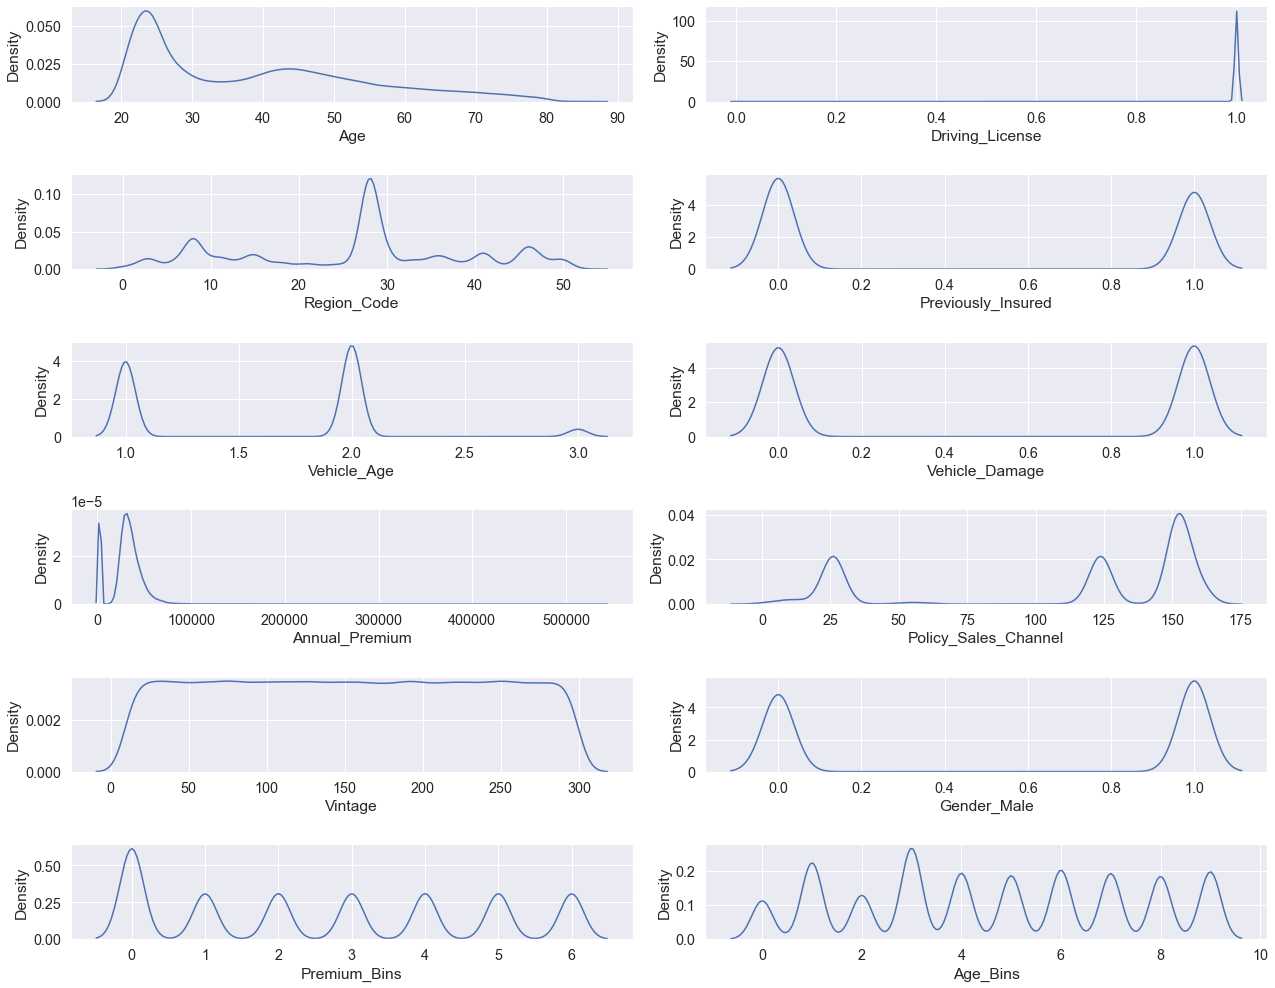

In [17]:
sns.set(font_scale=1.3)
fig, axes = plt.subplots(6, 2, figsize=(18, 14))
axes = [ax for axes_row in axes for ax in axes_row]
for i, col in enumerate(col_names):
    sns.kdeplot(train_proc[col],ax=axes[i])
plt.tight_layout()

From the above we can see, annual premium is skewed, most people are from region code 25-30, most of the customers are young, policy sales channel 150-160 is the most used, only few people have vehicle age of 3+ years  

# Visualizing hypothesis.

1)  Are younger people more like to buy insurnace? Since recently it is made compulsory?

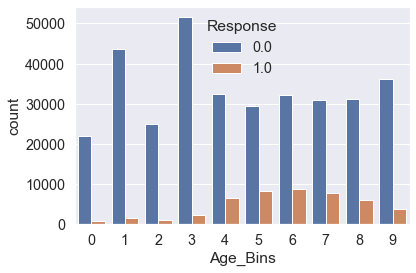

In [29]:
sns.countplot(x=train_proc["Age_Bins"], hue=train_proc["Response"], data=train_proc)

From the above we can say that people in the bins 4 to 8 are more likely to buy

2) Are people with DL more likely to buy vehicle insurance?

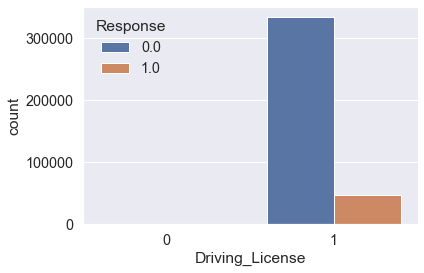

In [19]:
sns.countplot(x=train_proc["Driving_License"], hue=train_proc["Response"], data=train_proc)

Out of the people who have a driving license, majority haven't bought vehicle insurance. Also, there are very few people who don't have a driving license in our dataset.

3) Does region have an effect on purchase decision?

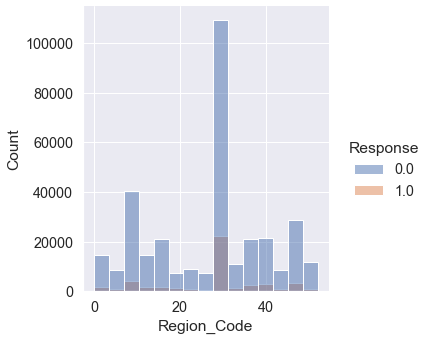

In [20]:
sns.displot(train_proc, x="Region_Code", hue="Response", bins=15)

We can see that there are few region codes where activity is high

4) Previously insured people more likely to buy again? 

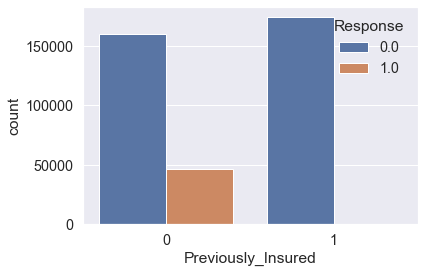

In [21]:
sns.countplot(x=train_proc["Previously_Insured"], hue=train_proc["Response"], data=train_proc)

Previously insured people have not brought it again

5) New vehicles more likely to buy insurance compared to old vehicles

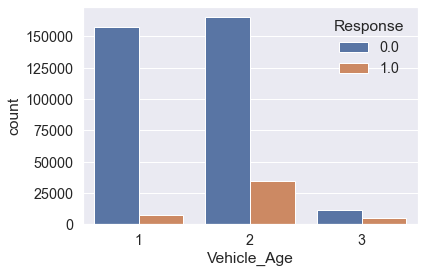

In [22]:
sns.countplot(x=train_proc["Vehicle_Age"], hue=train_proc["Response"], data=train_proc)

People with vehicle age 2 have bought it the most but in terms of percentage, vehicle age of 3+ have bought more. 

6) If customer has had damage in the past, he is more likely to buy vehicle insurance?

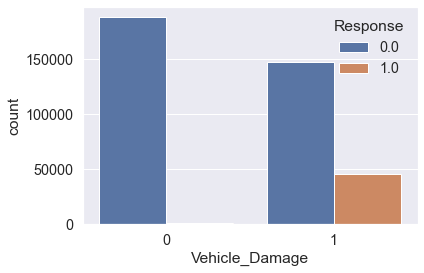

In [23]:
sns.countplot(x=train_proc["Vehicle_Damage"], hue=train_proc["Response"], data=train_proc)

People who have had vehicle damage are more likely to buy comapared to people who haven't faced vehicle damage.

7) Higher premium low chances of buying?

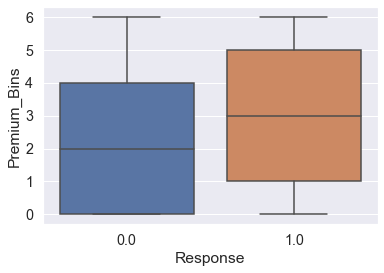

In [28]:
sns.boxplot(train_proc['Response'],train_proc['Premium_Bins'])